# Takehome Challenge
<br>
Ultimate Technologies<br>
Taylor Willingham<br>
September 2019<br>

## Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [127]:
import pandas as pd
from pandas import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [14]:
df = pd.read_json('logins.json')

After loading in the data, we see that it is just a collection of login times.

In [15]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Using the login times as the index, we can then resample and aggregate the logins for every 15 minutes. This is saved as `binned` and then stored as a dataframe called `counts`.

In [17]:
index = df.login_time

logins = pd.Series(range(len(df)), index=index)

binned = logins.resample('15T').count()
binned[:10]

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
1970-01-01 21:15:00    4
1970-01-01 21:30:00    0
1970-01-01 21:45:00    4
1970-01-01 22:00:00    9
1970-01-01 22:15:00    8
Freq: 15T, dtype: int64

In [59]:
counts = pd.DataFrame(binned, columns=['logins'])

counts.head()

,logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


To get started, we can first visualize the entire time series.

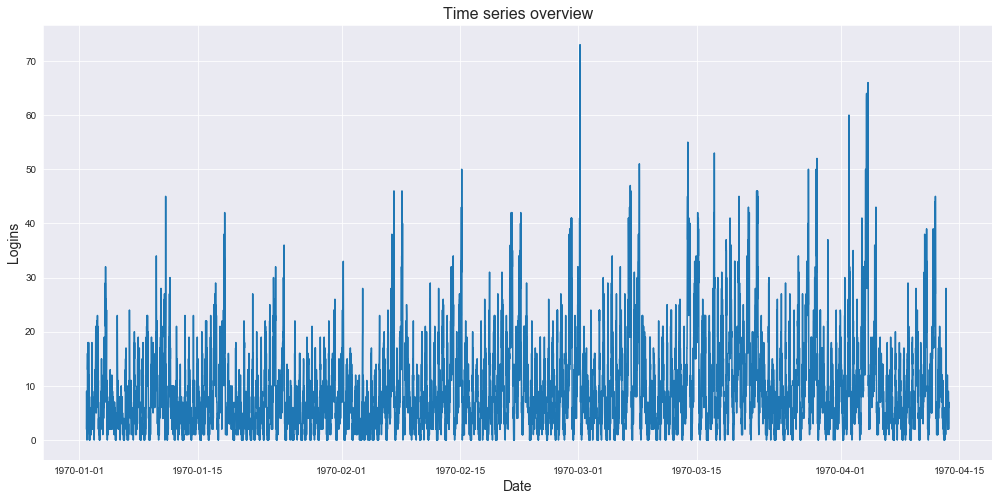

In [77]:
fig = plt.figure(figsize=(17,8))
_ = sns.lineplot(x=counts.index, y=counts.logins)
_ = plt.xlabel('Date', fontsize=14)
_ = plt.ylabel('Logins', fontsize=14)
_ = plt.title('Time series overview', fontsize=16)

The view is a bit cluttered, but there are a few takeaways. There seems to be a slight increase towards late March and early April, but the demand is fairly consistent overall. There are a couple spikes here and there, but those seem like isolated events. It's hard to see the daily trends, but it does hint at potential weekly cycles.<br>
<br>
To get a clearer picture we can use a rolling mean to smooth it out a bit. 

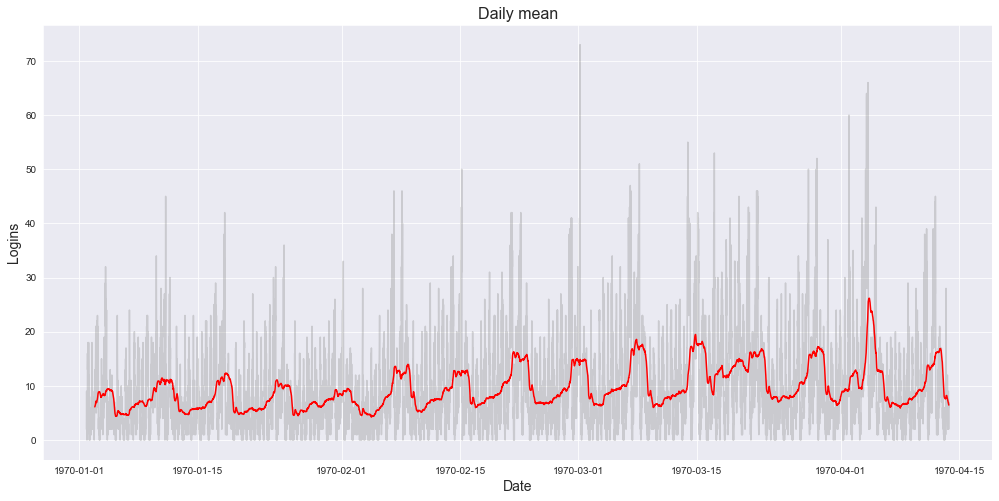

In [81]:
r = counts.rolling(window=96)

fig = plt.figure(figsize=(17,8))
_ = sns.lineplot(x=counts.index, y=counts.logins, color='gray', alpha=0.3)
_ = sns.lineplot(x=counts.index, y=r.mean()['logins'], color='red')
_ = plt.xlabel('Date', fontsize=14)
_ = plt.ylabel('Logins', fontsize=14)
_ = plt.title('Daily mean', fontsize=16)

For this plot, I chose a rolling window of 96 periods because there are 96 quarter hours in a day, so this should give us a sense of daily demand. This cuts out a lot of the noise and gives a better sense of the overall trends. Here we can clearly see the weekly cycles as demand intensifies towards the weekend and then drops off again. <br>
<br>
The curve around the third week of March is a little unusual which, if we had to hazard a guess, could be because of St. Patrick's Day occuring on the 17th. Responsible participants would not be driving that day increasing mid-week demand. There is also an interesting spike around early April. It's hard to provide a reason without more information, but we could reference the local calendar to see if there was some type of event that occurred.

To hone in further, we can remove the first 16 rows to start at 00:00:00, and then take the next 672 periods to get data for a full week to examine the weekly cycle.

In [88]:
first_wk = counts.head(688)
first_wk = first_wk.tail(672)
first_wk.head()

,logins
login_time,
1970-01-02 00:00:00,10
1970-01-02 00:15:00,18
1970-01-02 00:30:00,12
1970-01-02 00:45:00,13
1970-01-02 01:00:00,9


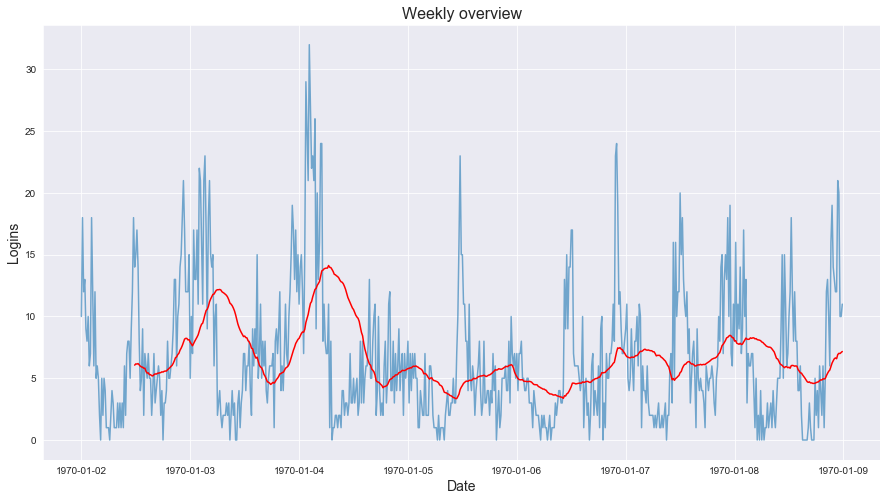

In [93]:
r_wk = first_wk.rolling(48)

fig = plt.figure(figsize=(15,8))
_ = sns.lineplot(x=first_wk.index, y=first_wk.logins, alpha=0.6)
_ = sns.lineplot(x=first_wk.index, y=r_wk.mean()['logins'], color='red')
_ = plt.xlabel('Date', fontsize=14)
_ = plt.ylabel('Logins', fontsize=14)
_ = plt.title('Weekly overview', fontsize=16)

The rolling window here is 12 hours so the aggregate line is a bit behind the actual data, but we can still get a sense of the trends. We can see the weekend surge followed by a fairly even distribution the rest of the week. Generally, it seems on a daily basis the highest demand is late at night with a lower surge around mid-day. There's also two periods each day, early morning and early evening, where logins are often at zero. Because we know the weekly cycles are similar, we can extrapolate these findings across the other weeks. 

## Part 2 - Experiment and Metrics Design<br>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### <b>Answer</b><br>
To truly answer this question properly, the first step would be to coordinate with the managers of city operations or the proper department to find out exactly what kind of data we have to work with. However, from the nature of the question, it sounds like we can see activity broken down by driver, likely relating to times of activity and geographical area.<br>
<br>
<b>Metric of interest</b><br>
As for the correct metric, I think the key to this problem is the times of driver activity as they relate to the busy periods for each city. Location seems like it might be important, but that is largely dependent on the needs of the riders, not the choices of the drivers. For me, the real answer lies in how drivers change their behavior in terms of what times they log in, specifically during weekdays  when each city is active at different times. If the toll bridge is a deterrent, then Metropolis drivers would likely drive mainly during the day when Metropolis is busy and then sign off in the evening, and the opposite should be true for Gotham drivers. Therefore, a good indication that the reimbursemnt experiment is working would be if drivers who normally only log in during the day on weekdays start giving more rides at night, and vice versa.<br>
<br>
<b>Experiment design</b><br>
Now that we know what to test, there are a couple things to consider when setting up the experiment. Most important is how we register whether or not a change has taken place. Looking at changes in activity from daytime to nighttime might not be practical because you would have to single out the habits of each driver to find ones that prefer day or night and then see if those habits change. That seems overly complicated. Instead, to generalize the problem, we could just look at the time ranges of activity for weekdays. Because the cities complement each other, that means it is always busy somewhere, so there is less incentive for a driver to cut short his or her drive time. So by eliminating the toll booth, we ultimately hope to see drivers stay active longer, which would mean more service for each city. The other consideration is how to split the groups for testing. Since we can't deny bridge access to certain drivers and it seems unfair to only reimburse half of the drivers, the best option is to compare activity between the periods before and after the change is implemented. <br>
<br>
To get the activity ranges, we could take the time of the first accepted ride each day and calculate the difference from the last accepted ride for each driver who logs in. Then we could test to see if the average range changes using A/B testing. For our purposes, a day that runs from 5:00am to 4:59am seems appropriate considering many drivers are active from night to early morning, but we shouldn't count that as two days. If there is overlap and we mistakenly get results in excess of 20 hours, we could discard those as outliers.<br>
<br>
With the data set, it's simply a matter of comparing the two periods and calculating the significance of the results. The null hypothesis is that there is no change, while the alternate hypothesis is that the range expands. From a distribution perspective, this is a one tail test because we are only interested in an increase. Once we have observed the differences, we would likely have enough data points so that we could use a t-test, or also bootstrapping, to calculate a p-value and come to a conclusion.<br>
<br>
If there is no increase, then the obvious suggestion is to abandon the experiment. If we find that the averange range does increase and that the p-value is low enough to indicate the observation is true, we should notify the city operations team that drivers seem inclined to take advantange of the program. At the very least, it would indicate that the experiment could be extended and different times of year could be compared to activity from previous years. From there, it's up to Ultimate to determine if the increase in activity is enough to compensate for the extra toll expenses the company will be required to cover. 

## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.<br>
<br>
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [142]:
# Load data into a dataframe and convert date strings to datetime

with open('ultimate_data_challenge.json') as file:
    data = json.load(file)

retention = pd.DataFrame(data)
retention[['last_trip_date', 'signup_date']] = retention[['last_trip_date', 'signup_date']].astype('datetime64[D]')
retention.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


The first thing to do is to find a way to determine retained users. The prompt for this question only mentions when the users signed up, not the date the data was pulled. But if we're mainly concerned with usage for the past 30 days, the signup period isn't very relevant. I think the best approach is to find the most recent date under `last_trip_date` and use the 30 days prior to that as our window of interest.

In [143]:
max(retention.last_trip_date)

Timestamp('2014-07-01 00:00:00')

So essentially, we are interested in any riders since June 1st.

In [144]:
retention['last_thirty'] = 0
retention.loc[retention.last_trip_date > '2014-06-01', 'last_thirty'] = 1
retention.head(10)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,last_thirty
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,1
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,0
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,0
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,0
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,0


Now we have our labels established under the column `last_thirty`. Any "retained" riders are marked with a 1 and all others are 0.<br> 
<br>
Now to compare the two labels.

In [145]:
percent = (len(retention[retention.last_thirty == 1]) / len(retention)) * 100
print('Percentage of retained riders is {:.2f}%'.format(percent))

Percentage of retained riders is 36.62%


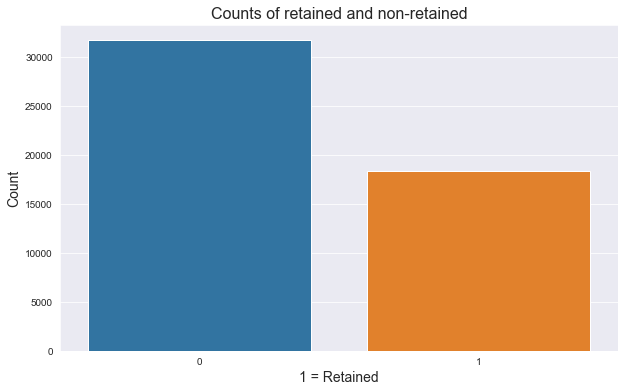

In [146]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
_ = sns.countplot(x='last_thirty', data=retention)
_ = plt.xlabel('1 = Retained', fontsize=14)
_ = plt.ylabel('Count', fontsize=14)
_ = plt.title('Counts of retained and non-retained', fontsize=16)

A little over a third of the riders have ridden in the past 30 days.<br>
<br>
Now to check for null values.

In [147]:
retention.isna().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
ultimate_black_user       False
weekday_pct               False
last_thirty               False
dtype: bool

In [148]:
nulls = retention.columns[retention.isna().any()]
retention[nulls].isna().sum()

avg_rating_by_driver     201
avg_rating_of_driver    8122
phone                    396
dtype: int64

Dropping 8,100 rows is not ideal, but `avg_rating_of_driver` seems like it could be an important indicator of rider satisfaction so imputing values could be risky. If we were to drop the null rows that would still leave over 40,000 observations, which is still a good size data set. Because of that reasoning I will opt to drop the rows with null values.

In [149]:
retention = retention.dropna()
retention.shape

(41445, 13)

With the null values dropped, we can continue to prep the dataset for machine learning. Primarily this means encoding categorical variables as numerical, and I also chose to drop the datetime columns. Converting them isn't very practical and their ordinal nature might cause confusion.

In [154]:
altered = retention.drop(['last_trip_date', 'signup_date'], axis=1)

In [158]:
altered = pd.get_dummies(altered, columns=['city', 'phone', 'ultimate_black_user'], drop_first=True)

The altered dataset is now ready, and we can take a look at the most impactful features.

In [161]:
altered.head(8)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,last_thirty,city_King's Landing,city_Winterfell,phone_iPhone,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1,1,0,1,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0,0,0,0,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0,0,0,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1,1,0,1,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0,0,1,0,0
5,10.56,5.0,3.5,1.00,0.0,2,100.0,1,0,1,1,1
7,2.04,5.0,5.0,1.00,0.0,2,100.0,0,0,1,1,0
8,4.36,5.0,4.5,1.00,0.0,2,100.0,0,0,1,0,0


In [162]:
from sklearn.feature_selection import SelectKBest, chi2

X = altered.loc[:, altered.columns != 'last_thirty']
y = altered.last_thirty

X_skb = SelectKBest(chi2, k=3).fit_transform(X,y)
print(X_skb.shape)

X_skb[:8]

(41445, 3)


array([[ 3.67,  4.  ,  1.  ],
       [ 8.26,  0.  ,  0.  ],
       [ 0.77,  3.  ,  0.  ],
       [ 2.36,  9.  ,  1.  ],
       [ 3.13, 14.  ,  0.  ],
       [10.56,  2.  ,  0.  ],
       [ 2.04,  2.  ,  0.  ],
       [ 4.36,  2.  ,  0.  ]])

Comparing the numbers from the truncated array to the full dataframe indicates that the three most impactful features are average distance, number of trips in the first 30 days, and being from King's Landing.<br>
<br>
Now to try and predict. For this I use Random Forest due to its feature_importances option allowing for interpretability. 

In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=4)

In [164]:
rf = RandomForestClassifier(n_estimators=100,\
                            oob_score=True,\
                            random_state=4,\
                            n_jobs=-1)

rf.fit(X_train, y_train)
print(rf.oob_score_)

0.7526455482403226


In [166]:
from sklearn.metrics import accuracy_score

pred = rf.predict(X_test)
accuracy_score(y_test, pred)

0.7551069647740067

The trained model seems generalizable to unseen data with an accuracy of around 75%. Now to look at the important features of the model.

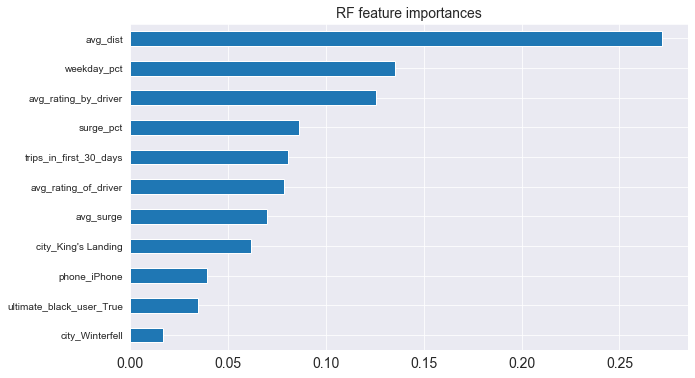

In [169]:
important = pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots(figsize=(10,6))
_ = important.plot(kind='barh')
_ = plt.title('RF feature importances', fontsize=14)

Unfortunately, the top three features are not the same as before, but average distance still looks to be an important variable. However, this doesn't indicate if longer or shorter distances are prefereable. Lets compare the retained and non-retained subsets.

In [174]:
cols = retention[['avg_dist', 'avg_rating_by_driver', 'trips_in_first_30_days', 'weekday_pct', 'last_thirty']]

# stats for retained riders
cols[cols.last_thirty == 1].describe()

,avg_dist,avg_rating_by_driver,trips_in_first_30_days,weekday_pct,last_thirty
count,16608.000000,16608.000000,16608.000000,16608.000000,16608.0
mean,4.914539,4.759387,3.617654,62.385814,1.0
std,4.135179,0.293452,5.164414,27.251023,0.0
min,0.000000,1.000000,0.000000,0.000000,1.0
25%,2.570000,4.600000,0.000000,46.700000,1.0
50%,3.680000,4.800000,2.000000,64.700000,1.0
75%,5.650000,5.000000,5.000000,83.300000,1.0
max,79.340000,5.000000,125.000000,100.000000,1.0


In [175]:
# stats for non-retained
cols[cols.last_thirty == 0].describe()

,avg_dist,avg_rating_by_driver,trips_in_first_30_days,weekday_pct,last_thirty
count,24837.000000,24837.000000,24837.000000,24837.000000,24837.0
mean,5.824816,4.787853,1.935661,60.498675,0.0
std,5.692917,0.463974,2.920521,39.044695,0.0
min,0.000000,1.000000,0.000000,0.000000,0.0
25%,2.310000,4.800000,0.000000,28.600000,0.0
50%,3.890000,5.000000,1.000000,66.700000,0.0
75%,7.240000,5.000000,2.000000,100.000000,0.0
max,79.690000,5.000000,73.000000,100.000000,0.0


Using different metrics gave us some variation in illustrating the important features, but the four features listed above seem like good choices for evaluation and further investigation -- particularly average distance and trips in the first 30 days. Judging by the differeces in stats, it appears that retained drivers tend to request shorter trips and ride more frequently. Perhaps Ultimate could use this information to focus their efforts to increase usage among  users in the first 30 days, perhaps with more enticing promotions, and promote their service as a viable short distance transportation option.